# Bioenergy Scenario Analysis – Côte d’Ivoire

This notebook explores regional bioenergy supply, technology adoption, and cost pathways based on the completed stockflow and cost pipelines.

📁 Inputs:
- `regional_supply_full_corrected.csv`
- `ci_bioenergy_techpathways.xlsx`
- Optional: `gadm41_CIV.gpkg` for maps

In [6]:
# 1. Load Libraries
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [7]:
# 2. Load Datasets
supply_df = pd.read_csv("data/regional_supply_full_corrected.csv")
summary_df = pd.read_excel("results/ci_bioenergy_techpathways.xlsx", sheet_name="Summary")

## 3. Total Biomass by District

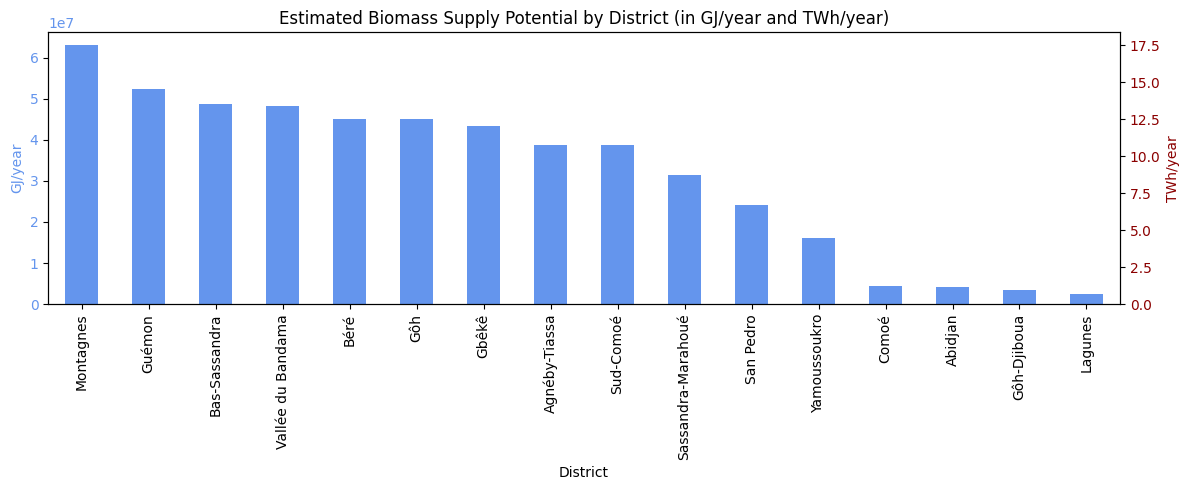

In [18]:
import matplotlib.ticker as ticker

# Aggregate and convert
district_supply = supply_df.groupby("District")["Available_GJ"].sum().sort_values(ascending=False)
district_supply_twh = district_supply / 3_600_000  # Convert GJ to TWh

# Plot primary axis (GJ)
fig, ax1 = plt.subplots(figsize=(12, 5))
district_supply.plot(kind="bar", ax=ax1, color="cornflowerblue")
ax1.set_ylabel("GJ/year", color="cornflowerblue")
ax1.tick_params(axis='y', labelcolor="cornflowerblue")

# Secondary axis (TWh)
ax2 = ax1.twinx()
district_supply_twh.plot(kind="bar", ax=ax2, alpha=0)
ax2.set_ylabel("TWh/year", color="darkred")
ax2.tick_params(axis='y', labelcolor="darkred")
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Total biomass supply potential for cooking fuel applications, including firewood, charcoal, cocoa pods, and agricultural residues. Estimates are based on region-specific sources and household demand projections.

plt.title("Estimated Biomass Supply Potential by District (in GJ/year and TWh/year)")
plt.tight_layout()
plt.show()

## 4. Load and Compare Scenario Costs

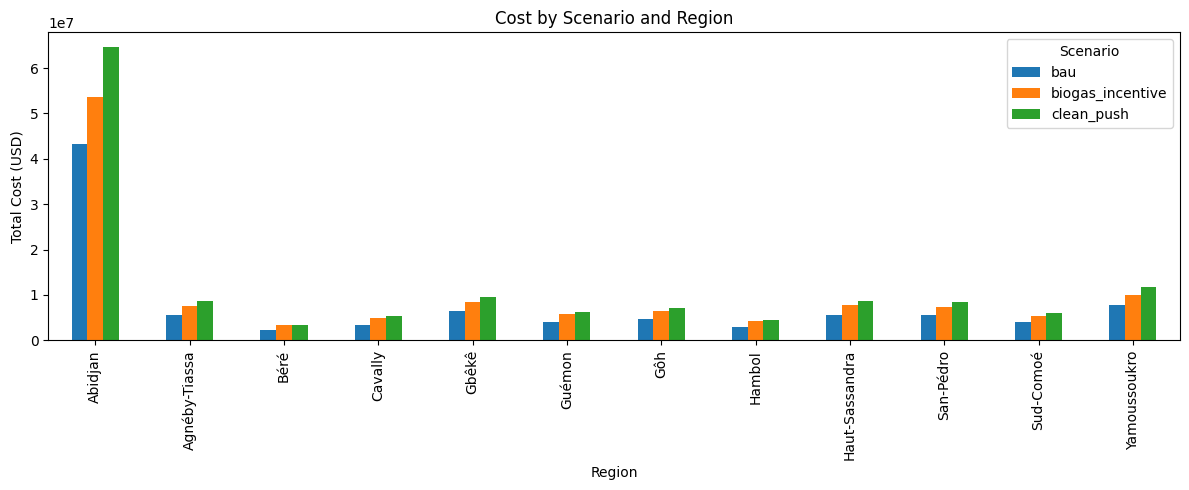

In [12]:
scenario_2030 = summary_df[(summary_df["Year"] == 2030)]
pivot = scenario_2030.pivot(index="Region", columns="Scenario", values="Total_Cost_USD")

# Regional breakdown of total household energy expenditures for cooking across three scenarios — Business-as-Usual (BAU), Moderate Transition, and Net-Zero — over the period 2030–2050. 
# Costs include biomass, LPG, electricity, and alternative clean fuel options.
pivot.plot(kind="bar", figsize=(12,5), title="Projected Household Cooking Fuel Costs by Scenario and Region")
plt.ylabel("Total Cost (USD)")
plt.tight_layout()

## Scenario Comparison by Region (2030, 2040, 2050)

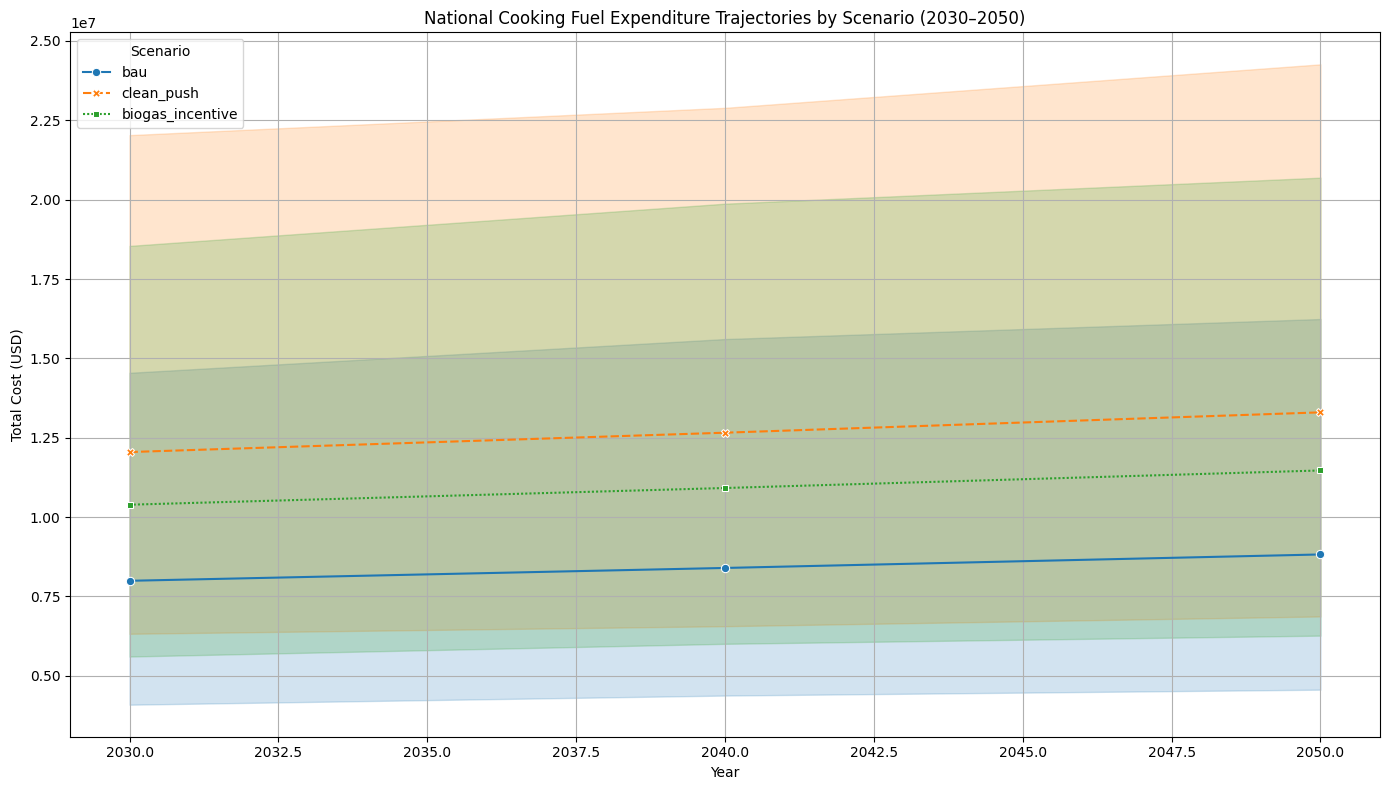

In [22]:
import seaborn as sns

# Filter only relevant years
years_df = summary_df[summary_df["Year"].isin([2030, 2040, 2050])]

# Set up the plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=years_df, x="Year", y="Total_Cost_USD", hue="Scenario", style="Scenario", markers=True)

# National-level trends in projected household expenditures on cooking energy, disaggregated by scenario. 
# The model includes adoption of LPG, improved cookstoves, biomass briquettes, and electricity under varying technology diffusion pathways.
plt.title("National Cooking Fuel Expenditure Trajectories by Scenario (2030–2050)")
plt.ylabel("Total Cost (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 🗺 5. Spatial Join and Map (Optional)
Upload and join with `gadm41_CIV.gpkg` when ready

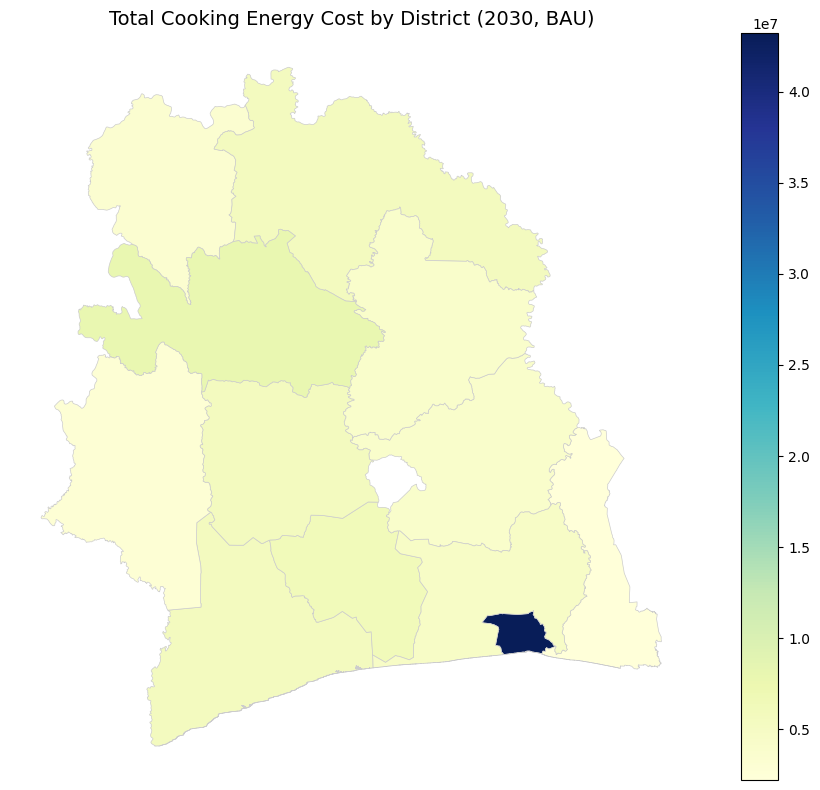

In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
GEO_PATH = "data/gadm41_CIV.gpkg"  # replace as needed
EXCEL_PATH = "results/ci_bioenergy_techpathways.xlsx"
YEAR = 2030
SCENARIO = "bau"
# ----------------------------

# Load GeoDataFrame
adm1 = gpd.read_file(GEO_PATH, layer=1).reset_index()
adm1["District_ID"] = adm1.index + 1  # simple numeric IDs

# Load scenario data
df = pd.read_excel(EXCEL_PATH, sheet_name="Summary")
df_filtered = df[(df["Year"] == YEAR) & (df["Scenario"] == SCENARIO)].reset_index(drop=True)
df_filtered["District_ID"] = df_filtered.index + 1

# Merge on numeric ID
merged = adm1.merge(df_filtered[["District_ID", "Total_Cost_USD"]], on="District_ID", how="left")

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
merged.plot(column="Total_Cost_USD", cmap="YlGnBu", linewidth=0.5, edgecolor="0.8", legend=True, ax=ax)
ax.set_title(f"Total Cooking Energy Cost by District ({YEAR}, {SCENARIO.upper()})", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
import geopandas as gpd
from difflib import get_close_matches

# Load shapefile (ADM1)
adm1 = gpd.read_file("data/gadm41_CIV.gpkg", layer=1)
adm1_names = adm1["NAME_1"].dropna().unique()

# Load scenario Excel
df = pd.read_excel("results/ci_bioenergy_techpathways.xlsx", sheet_name="Summary")
df_bau = df[(df["Year"] == 2030) & (df["Scenario"] == "bau")]
region_names = df_bau["Region"].dropna().unique()

# Perform fuzzy matching
mapping = {}
for region in region_names:
    match = get_close_matches(region, adm1_names, n=1, cutoff=0.4)
    mapping[region] = match[0] if match else None

# Convert to DataFrame
mapping_df = pd.DataFrame(list(mapping.items()), columns=["Excel_Region", "ADM1_Match"])

# Export to CSV
mapping_df.to_csv("region_name_mapping_table.csv", index=False)
print("✅ Mapping table saved as 'region_name_mapping_table.csv'")

✅ Mapping table saved as 'region_name_mapping_table.csv'
